# Sample SCRUF output processing
This file contains examples of processing and visualizating the output from a run of SCRUF.

## Imports

In [1]:
import pandas as pd
import numpy as np
import json
import jsonlines
import matplotlib.pyplot as plt
import seaborn as sb

## Reading data frame from post-processing output

In [4]:
output_df = pd.read_csv('sample_output.csv', header=[0,1], index_col=0)

Note that it produces a DataFrame with a multilevel index for the columns

In [5]:
output_df.head()

Fairness Metric      Compatibility     Allocation            \
                1    2             1   2          1    2 none   
0             1.0  1.0           NaN NaN        0.0  0.0    1   
1             0.0  1.0           NaN NaN        1.0  0.0    1   
2             1.0  1.0           NaN NaN        0.0  0.0    1   
3             1.0  1.0           NaN NaN        0.0  0.0    1   
4             1.0  1.0           NaN NaN        0.0  0.0    1   

                                             Results  \
                                                  In   
0  [('3484', 7.86710150118139), ('2367', 6.353344...   
1  [('3961', 5.367536723913962), ('590', 5.355241...   
2  [('3484', 5.705318104846835), ('1607', 4.70980...   
3  [('3816', 11.64300547825603), ('663', 10.57495...   
4  [('4042', 3.562563204046363), ('4052', 3.01622...   

                                                          nDCG Exposure       
                                                 Out       All        1    2  
0  [('3484', 49.0), ('2367', 48.0), ('2802', 47.0...  1.000000      0.0  0.1  
1  [('590', 46.888888888888886), ('992', 41.11111...  0.821948      0.5  0.4  
2  [('3484', 49.0), ('1607', 48.0), ('1268', 47.0...  1.000000      0.1  0.3  
3  [('3816', 49.0), ('663', 48.0), ('1434', 47.0)...  1.000000      0.2  0.2  
4  [('4042', 49.0), ('4052', 48.0), ('3093', 47.0...  1.000000      0.1  0.3

## Time series visualizations

In [10]:
def plot_fairness_time(results_df, include_none=False, image_prefix=None):
    fair_df = results_df['Fairness Metric']
    fig, ax = plt.subplots(figsize=(10, 6))
    sb.set(font_scale=2)
    plt.xlabel("Time")
    plt.ylabel("Fairness")
    sb.lineplot(data=fair_df)
    if image_prefix is not None:
        image_file = image_prefix + '-fairness.png'
        plt.savefig(image_file)

def plot_allocation(results_df, include_none=False, image_prefix=None):
    alloc_df = results_df['Allocation']
    if include_none is False:
        if not alloc_df['none'][1:].any():
            alloc_df.drop('none', axis=1, inplace=True)
    fig, ax = plt.subplots(figsize=(10, 6))
    sb.set(font_scale=2)
    plt.xlabel("Time")
    plt.ylabel("Allocation")
    sb.lineplot(data=alloc_df.cumsum())
    if image_prefix is not None:
        image_file = image_prefix + '-allocation.png'
        plt.savefig(image_file)
        
def plot_compatibility(results_df, include_none=False, image_prefix=None):
    compat_df = results_df['Compatibility']
    fig, ax = plt.subplots(figsize=(10, 6))
    sb.set(font_scale=2)
    plt.xlabel("Time")
    plt.ylabel("Compatibility")
    sb.lineplot(data=compat_df)
    if image_prefix is not None:
        image_file = image_prefix + '-compatibility.png'
        plt.savefig(image_file)

def plot_fairness_regret(results_df, include_none=False, image_prefix=None):
    fair_df = results_df['Fairness Metric']
    regret = 1-fair_df
    fig, ax = plt.subplots(figsize=(10, 6))
    sb.set(font_scale=2)
    plt.xlabel("Time")
    plt.ylabel("Fairness Regret")
    sb.lineplot(data=regret.cumsum())
    if image_prefix is not None:
        image_file = image_prefix + '-regret.png'
        plt.savefig(image_file)

def do_plots(experiment_data, include_none=False, image_prefix=None):
    plot_fairness_time(experiment_data, include_none, image_prefix)
    plot_compatibility(experiment_data, include_none, image_prefix)
    plot_allocation(experiment_data, include_none, image_prefix)
    plot_fairness_regret(experiment_data, include_none, image_prefix)

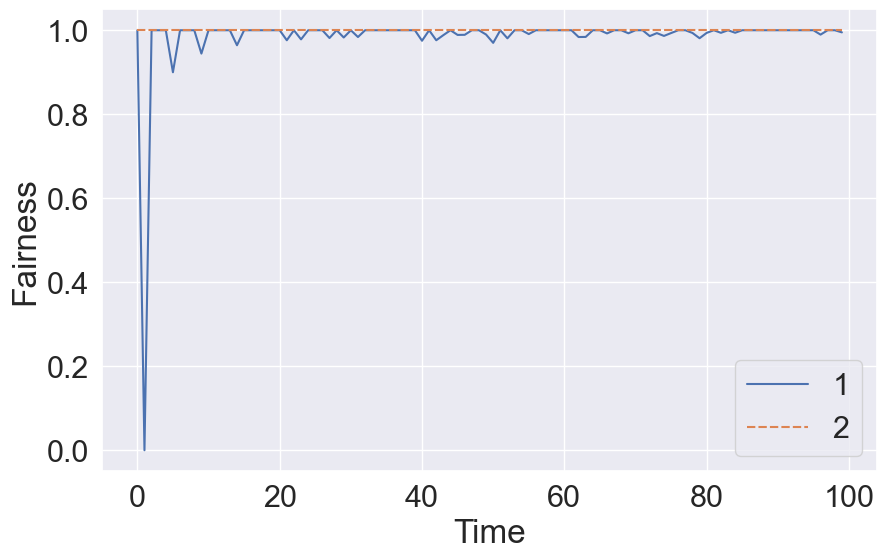

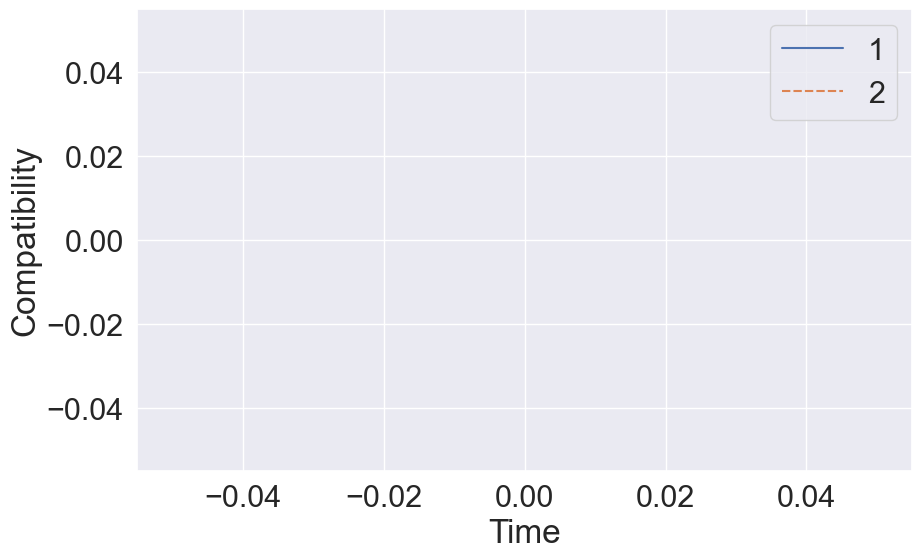

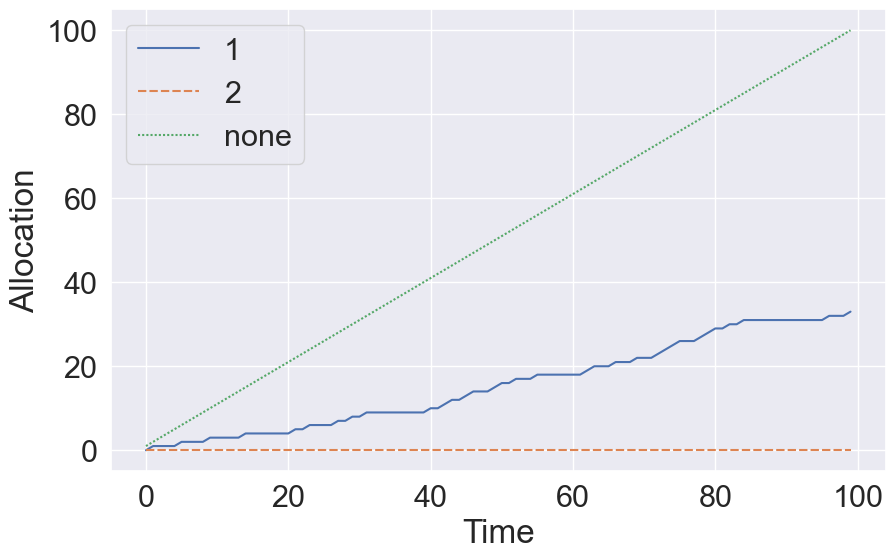

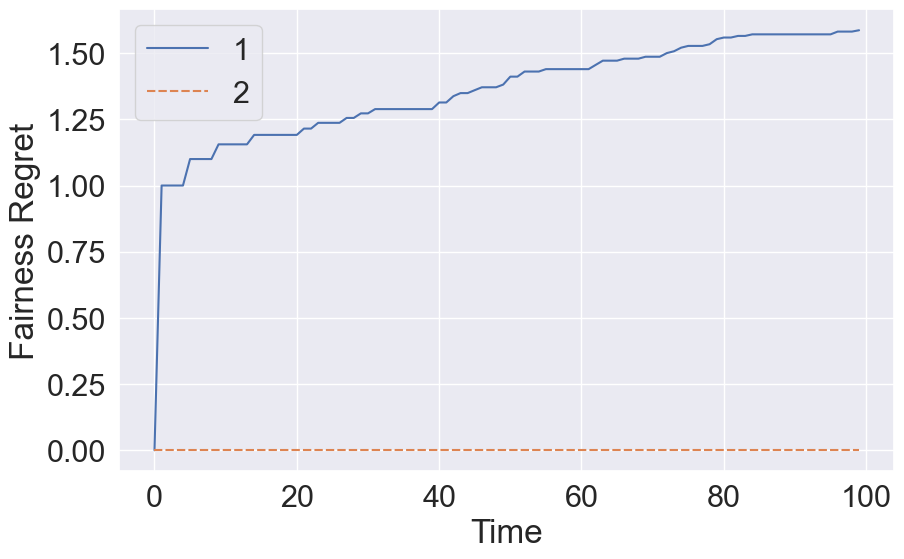

In [11]:
do_plots(output_df, include_none=True)

[Text(0, 0, '')]

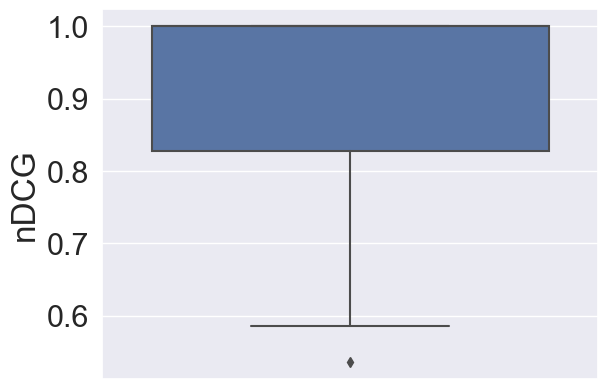

In [23]:
ax = sb.boxplot(output_df.nDCG)
plt.ylabel("nDCG")
ax.set_xticklabels([""])

Text(0, 0.5, 'Exposure')

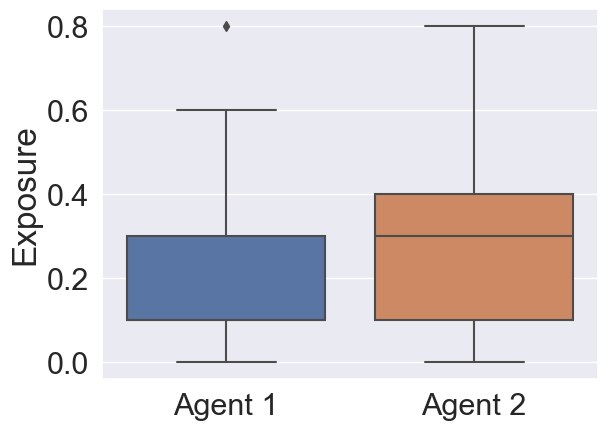

In [24]:
ax = sb.boxplot([output_df[('Exposure', '1')], output_df[('Exposure', '2')]])
ax.set_xticklabels(['Agent 1', 'Agent 2'])
plt.ylabel('Exposure')

In [231]:
output_df.to_csv('sample_output.csv')